In [136]:
import h5py
import numpy as np
import operator
import visualisation
import pandas as pd
import matplotlib.pyplot as plt
from dtw import dtw

from sporco import plot, util
from sporco.admm import cbpdn
from sporco.dictlrn import cbpdndl
from numpy.fft import rfft, rfftfreq
from itertools import tee

import scipy.signal as sg
from scipy.signal import butter, lfilter, freqz



plt.rcParams["figure.figsize"] = (16,8)


## Load the data

In [35]:
PATH_TO_TRAINING_DATA = "additional_files_dreem/X_train_denoised_array.h5"
PATH_TO_TRAINING_TARGET = "data/y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))

/Users/Claudia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
X_train = np.array(h5_file.get('data'))

Separation of signals containing at least one apnea event and those who are completely normal sleep.

In [37]:
idx_apnea_signals = []
idx_normal_signals = []
for i in range(4400):
    if 1 in mask[i,1:]:
        idx_apnea_signals += [i]
    else:
        idx_normal_signals += [i]

## Exploration of respiratory signals for a normal sleep

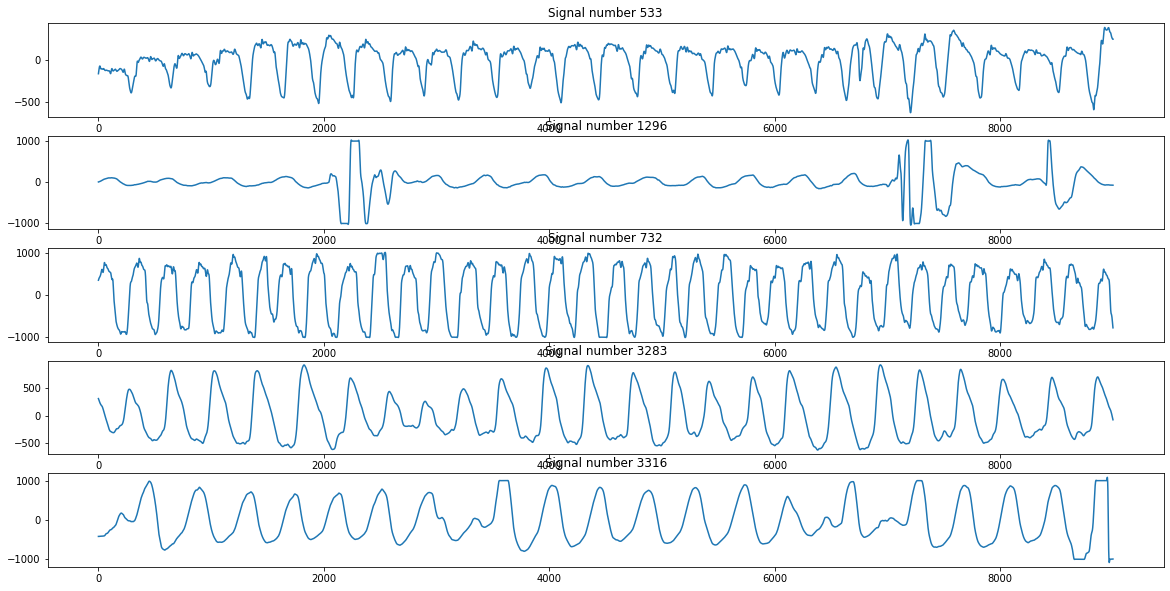

In [38]:
n_signals = 5
chosen_signals = np.random.randint(len(idx_normal_signals),size=n_signals)

fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[0,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

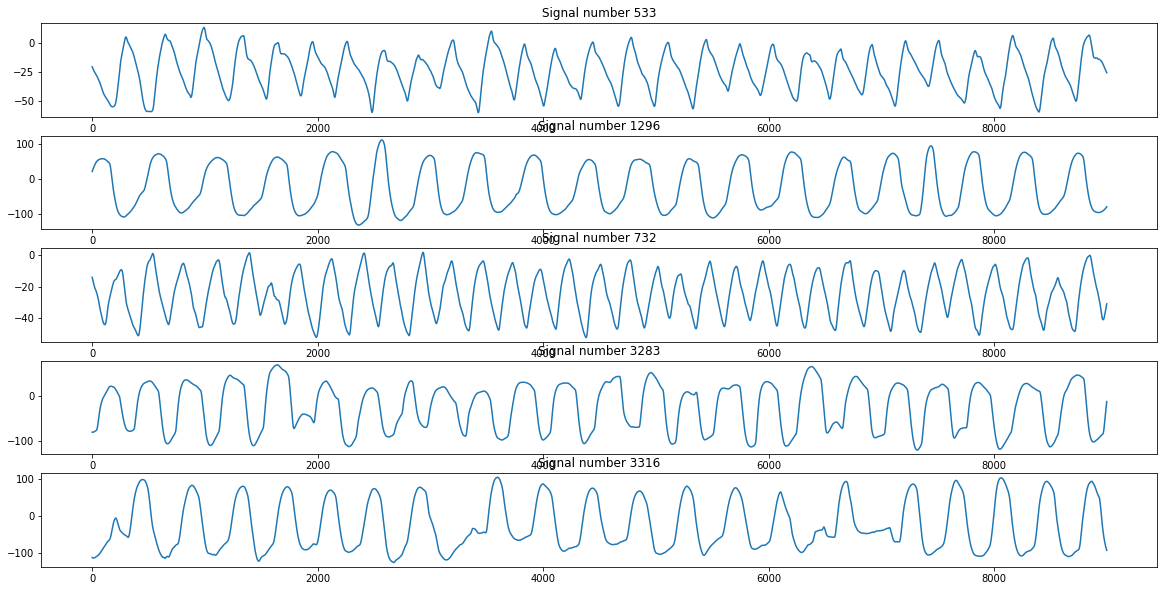

In [39]:
fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[1,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

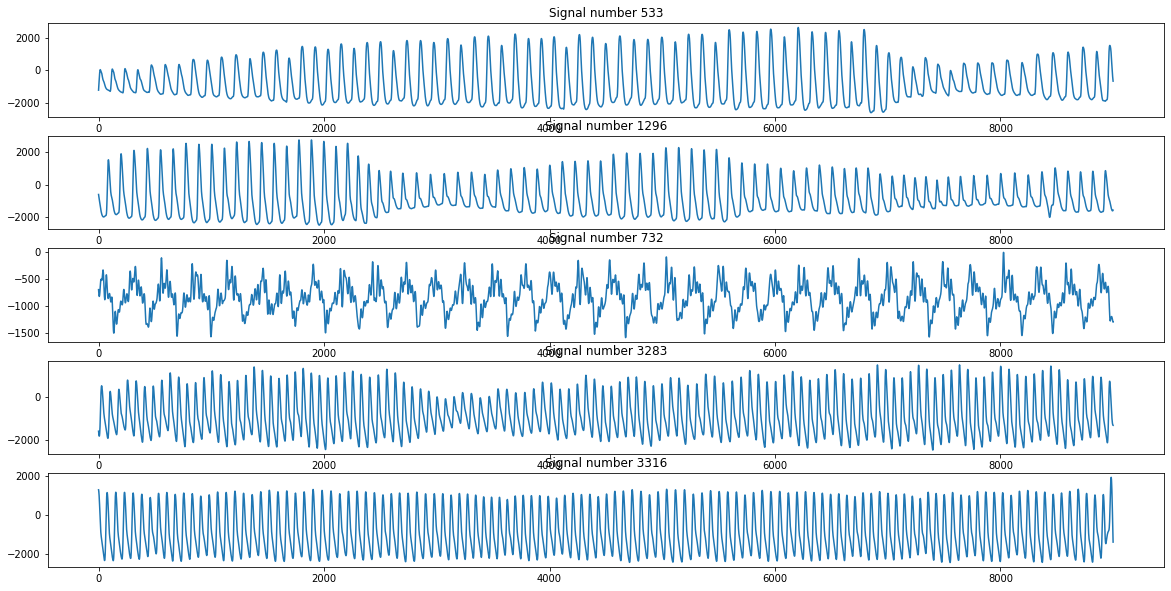

In [40]:
fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[2,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

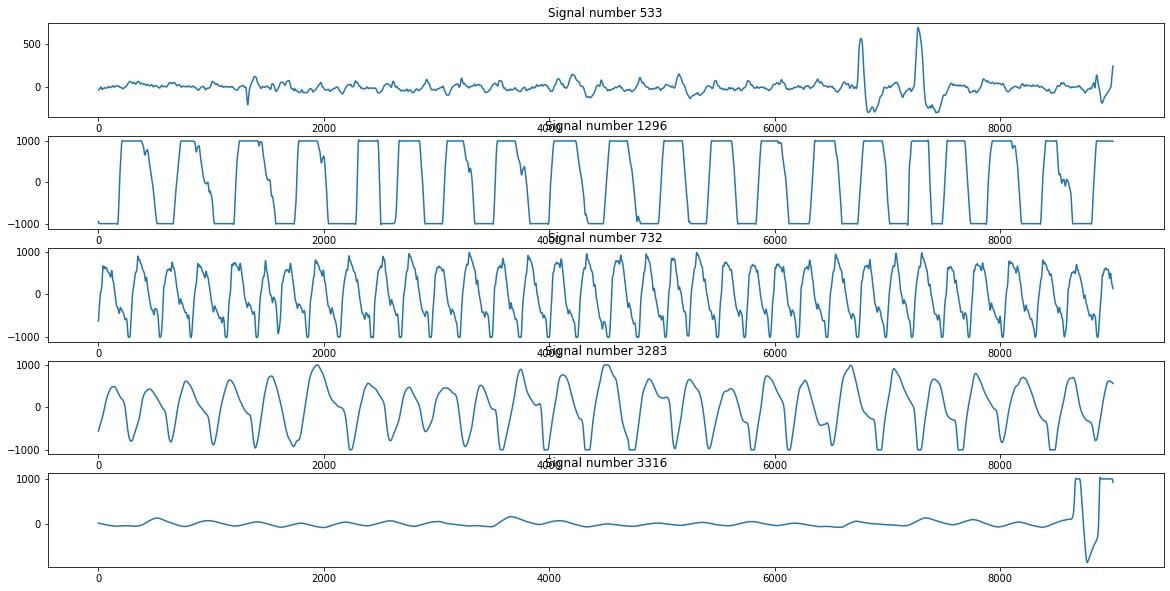

In [41]:
fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[3,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

## Utility functions for CDL

In [42]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [43]:
def atleast_2d(ary):
    """Reshape array to at least two dimensions."""
    if ary.ndim == 0:
        return ary.reshape(1, 1)
    elif ary.ndim == 1:
        return ary[:, np.newaxis]
    return ary

In [44]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

## CDL on a single signal

For a 1D signal $\mathbf{x}\in\mathbb{R}^N$ with $N$ samples, the convolutional dictionary learning tasks amounts to solving the following optimization problem:

$$
\min_{(\mathbf{d}_k)_k, (\mathbf{z}_k)_k \\ \lVert\mathbf{d}_k\rVert^2\leq 1} \quad\left\lVert \mathbf{x} - \sum_{k=1}^K \mathbf{z}_k * \mathbf{d}_k \right\rVert^2 \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_k\rVert_1
$$

where $\mathbf{d}_k\in\mathbb{R}^L$ are the $K$ dictionary atoms (patterns), $\mathbf{z}_k\in\mathbb{R}^{N-L+1}$ are activations signals, and $\lambda>0$ is the sparsity constraint.

This problem is not convex with respect to the couple $(\mathbf{d}_k)_k, (\mathbf{z}_k)_k$ but convex when the subproblems are taken individually.

In [45]:
# In this cell, we set parameters and options that should probably remained unchanged
PENALTY = 3

# options for the dictionary learning and sparse coding procedures
def get_opt_dl(penalty=PENALTY):
    """Return the option class for the dictionary learning"""
    return cbpdndl.ConvBPDNDictLearn.Options(
        {
            "Verbose": False,
            "MaxMainIter": 50,
            "CBPDN": {"rho": 50.0 * penalty + 0.5, "NonNegCoef": True},
            "CCMOD": {"rho": 10.0},
        },
        dmethod="cns",
    )


def get_opt_sc():
    """Return the option class for the sparse coding"""
    return cbpdn.ConvBPDN.Options(
        {
            "Verbose": False,
            "MaxMainIter": 50,
            "RelStopTol": 5e-3,
            "AuxVarObj": False,
            "NonNegCoef": True,  # only positive sparse codes
        }
    )

Let's apply dictionary learning on the first normal signal.

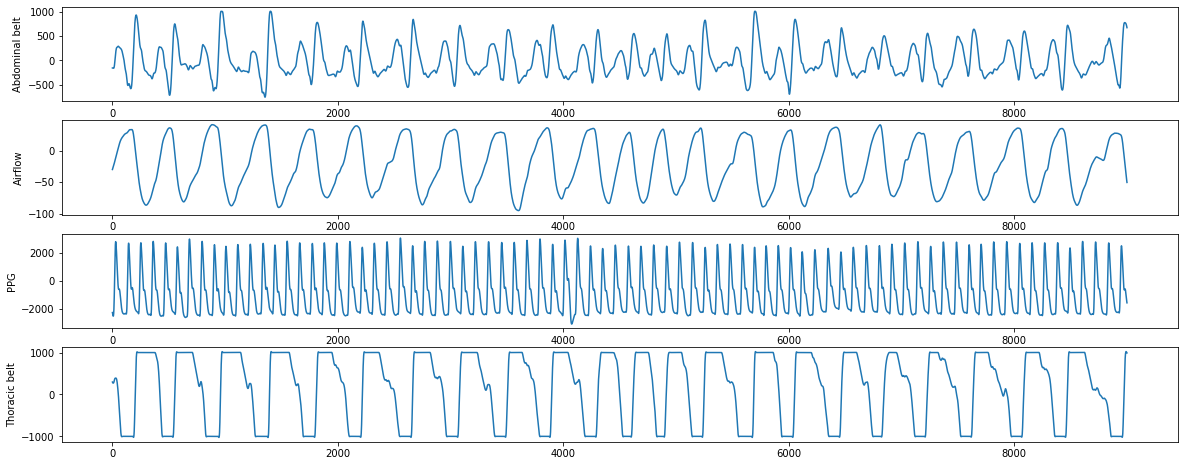

In [46]:
labels = ["Abdominal belt", "Airflow", "PPG", "Thoracic belt", "Snoring indicator", "SPO2", "C4-A1", "O2-A1"]

fig, ax = plt.subplots(nrows=4, figsize=(20,8))
for i in range(4):
    ax[i].plot(X_train[i, idx_normal_signals[1]])
    ax[i].set_ylabel(labels[i])

In [47]:
# Parameters to change
n_atoms = 3
atom_length = 500
penalty = 4

# Select a signal
signal = X_train[1, idx_normal_signals[0]]
signal = atleast_2d(signal)  # reshape

# Random number generator
rng = np.random.RandomState(seed=123)

In [48]:
# get options for the optimizations
opt_dl = get_opt_dl(penalty=penalty)
opt_sc = get_opt_sc()

# Dictionary learning and sparse coding
dict_learning = cbpdndl.ConvBPDNDictLearn(
    D0=rng.randn(atom_length, 1, n_atoms),  # random init
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_dl,  # options for the optimizations
    xmethod="admm",  # optimization method (sparse coding)
    dmethod="cns",  # optimization method (dict learnin)
)
atom_dictionary = dict_learning.solve()

# retrieve the sparse codes
basis_pursuit = cbpdn.ConvBPDN(
    D=atom_dictionary,  # learned dictionary
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_sc,  # options for the optimizations
)
sparse_codes = basis_pursuit.solve().squeeze()

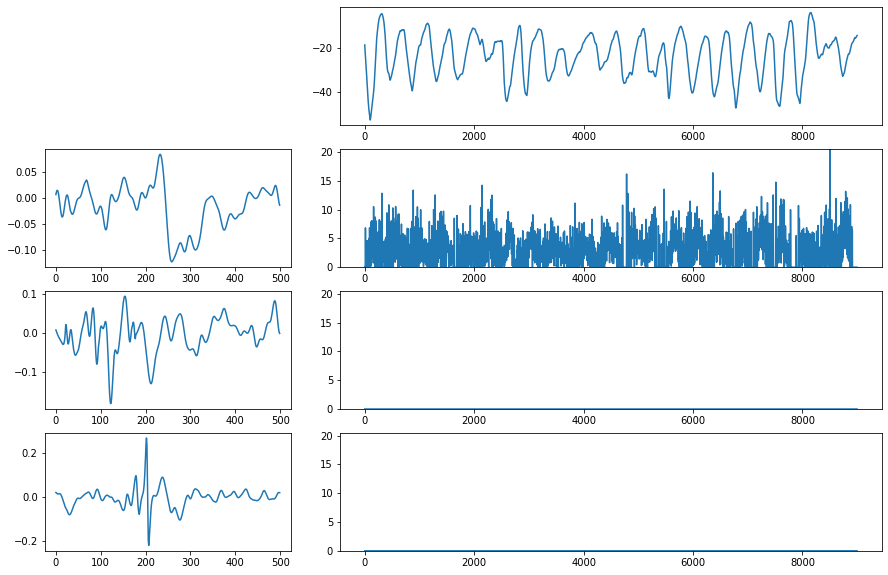

In [49]:
plot_CDL(
    signal, atleast_2d(sparse_codes), atleast_2d(atom_dictionary.squeeze())
)

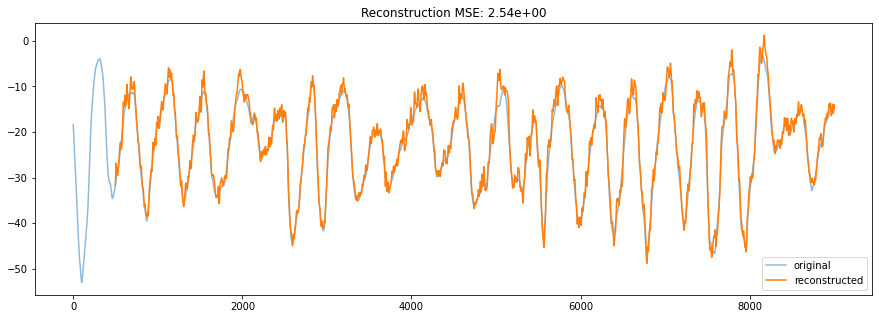

In [50]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = np.stack(
    [
        np.convolve(code, atom, mode="valid")
        for (code, atom) in zip(
            atleast_2d(sparse_codes).T, atleast_2d(atom_dictionary.squeeze()).T
        )
    ],
    axis=0,
)

# Note that the reconstruction has less samples than the original signal.
# This is because of border effects of the convolution.
offset = atom_length - 1

fig, ax = fig_ax()
tt = np.arange(signal.shape[0])
ax.plot(tt, signal, label="original", alpha=0.5)
ax.plot(tt[offset:], reconstruction.sum(axis=0), label="reconstructed")
ax.set_title(
    f"Reconstruction MSE: {np.mean((signal[offset :].flatten() - reconstruction.sum(axis=0))**2):.2e}"
)
_ = plt.legend()

Finding a dictionary is hard.
Let's use peaks

In [51]:
def keep_peaks(peaks, treshold):
    time_diff_peaks = (peaks[1:] - peaks[:-1])/100.
    #plt.hist(time_diff_peaks,10)
    drop_values = np.where(time_diff_peaks < treshold)[0]
    time_diff_peaks = np.delete(time_diff_peaks, drop_values)
    return(np.delete(peaks,drop_values+1), time_diff_peaks)

Signal 0
Average interval between peaks : 3.79, var : 0.13, median : 3.82, min : 3.36, max : 4.54  
Signal 1
Average interval between peaks : 4.18, var : 0.10, median : 4.23, min : 3.68, max : 4.78  
Signal 2
Average interval between peaks : 1.19, var : 0.00, median : 1.19, min : 1.16, max : 1.22  
Signal 3
Average interval between peaks : 3.81, var : 0.95, median : 4.19, min : 0.85, max : 4.66  


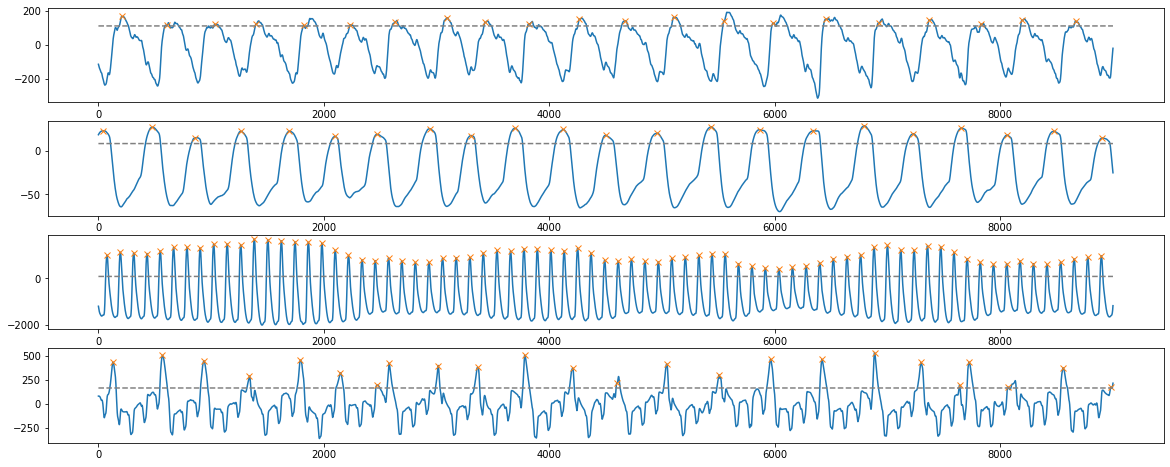

In [52]:
signal_id = idx_normal_signals[3383]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    ax[i].plot(peaks, signal_i[peaks], "x")
    
    ax[i].plot(np.zeros_like(signal_i)+ treshold, "--", color="gray")

Signal 0
Average interval between peaks : 2.64, var : 1.08, median : 2.70, min : 1.15, max : 4.42  
Signal 1
Average interval between peaks : 3.92, var : 0.19, median : 3.95, min : 2.99, max : 4.71  
Signal 2
Average interval between peaks : 1.12, var : 0.00, median : 1.12, min : 1.02, max : 1.18  
Signal 3
Average interval between peaks : 2.77, var : 0.23, median : 2.88, min : 1.90, max : 3.70  


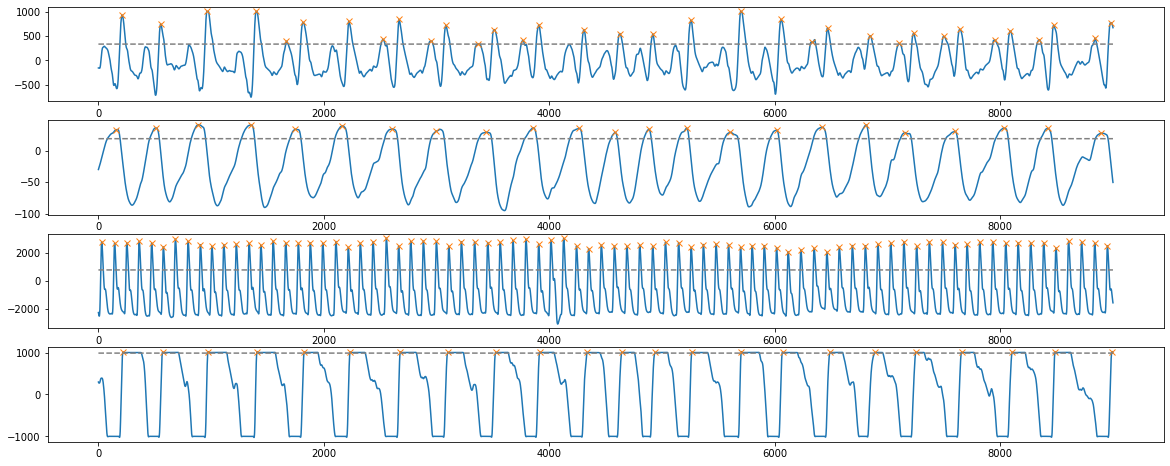

In [53]:
signal_id = idx_normal_signals[1]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    signal_i = X_train[i, signal_id]
    treshold = signal_i.mean()+ signal_i.std()
    ax[i].plot(signal_i)
    peaks, _ = sg.find_peaks(signal_i,height= treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")

Signal 0
Average interval between peaks : 6.42, var : 0.00, median : 6.42, min : 6.42, max : 6.42  
Signal 1
Average interval between peaks : 4.78, var : 10.04, median : 4.09, min : 3.28, max : 17.77  
Signal 2
Average interval between peaks : 0.77, var : 0.02, median : 0.76, min : 0.68, max : 2.05  
Signal 3
Average interval between peaks : 4.22, var : 10.35, median : 3.38, min : 2.70, max : 16.89  


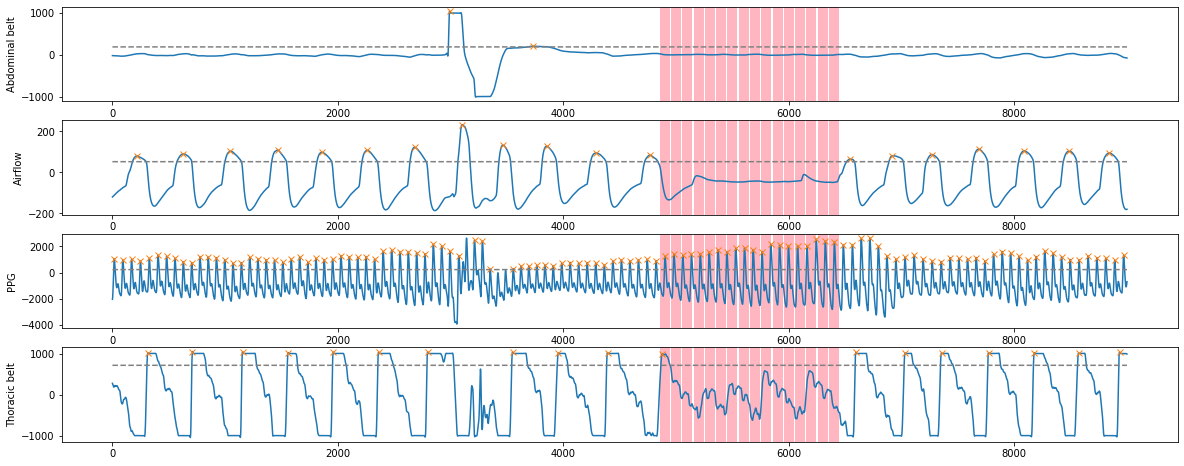

In [54]:
signal_id = idx_apnea_signals[37]
apneas_i = np.where(mask[signal_id] == 1)[0]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    for idx in range(apneas_i.size):
        ax[i].axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    time_diff_peaks = []
    #peaks, _ = sg.find_peaks(signal_i,height=0)
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
    ax[i].set_ylabel(labels[i])
    
    

[ 1.89  1.87  2.51  2.28  2.93  3.24  3.56  3.46  3.4  16.4   2.88  2.58
  2.37  3.17  3.08  3.19  3.56]
[ 1.87  1.9   2.57  2.28  2.95  3.32  3.62  3.43  3.37  2.84  3.28 10.32
  2.87  2.62  2.33  3.22  3.04  3.14  3.5   3.93 12.77]
[1.21 1.15 1.17 1.01 1.13 3.14 2.22 1.08 2.2  1.13 1.15 1.08 1.14 1.12
 1.07 1.14 1.11 1.09 1.14 1.14 1.11 1.17 1.17 1.12 1.18 1.19 1.22 1.23
 1.24 1.26 1.27 1.26 1.24 1.25 1.23 1.22 1.17 1.17 1.17 1.07 1.12 1.04
 2.26 3.5  1.21 1.27 1.18 1.25 1.28 1.22 1.24 1.24 1.25 1.28 1.27 1.27
 1.31 1.29 1.31 1.25 1.31 1.32 1.27 1.28 1.25 1.28 1.24 1.26]
[ 2.03  3.1   2.26  2.57  2.86  2.87  2.8   2.72  0.67  2.75 15.97  2.59
  2.23  3.25  3.13  3.05  3.39 16.54]


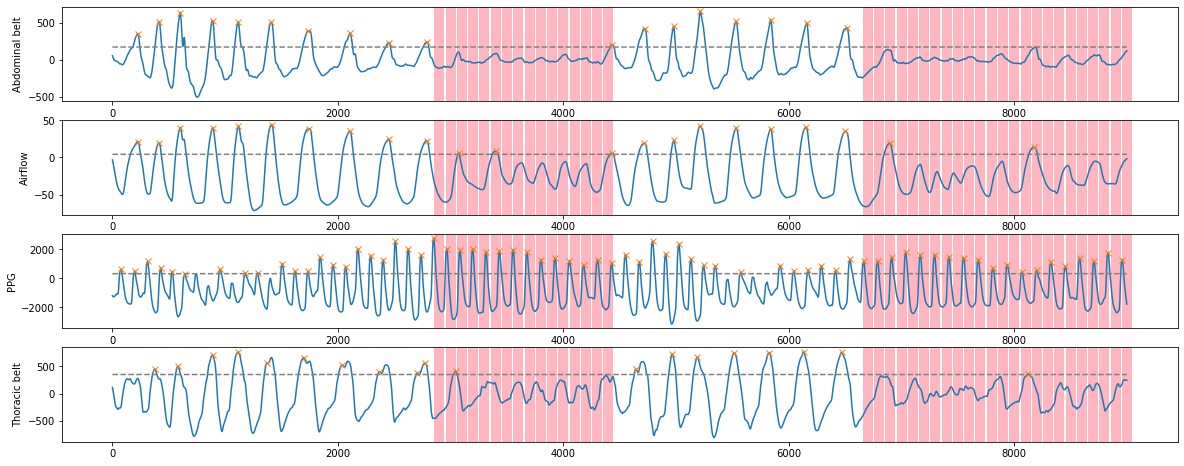

In [55]:
signal_id = idx_apnea_signals[100]
apneas_i = np.where(mask[signal_id] == 1)[0]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    for idx in range(apneas_i.size):
        ax[i].axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, mean = keep_peaks(peaks, 0.6)
    print(mean)
    
    time_diff_peaks = []
    #peaks, _ = sg.find_peaks(signal_i,height=0)
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
    ax[i].set_ylabel(labels[i])
    
    

Signal 0
Average interval between peaks : 3.92, var : 12.98, median : 2.54, min : 1.86, max : 14.39  
Signal 1
Average interval between peaks : 6.01, var : 17.48, median : 3.84, min : 2.87, max : 15.70  
Signal 2
Average interval between peaks : 1.17, var : 0.06, median : 1.09, min : 0.87, max : 1.80  
Signal 3
Average interval between peaks : 5.30, var : 34.60, median : 2.99, min : 0.66, max : 21.44  


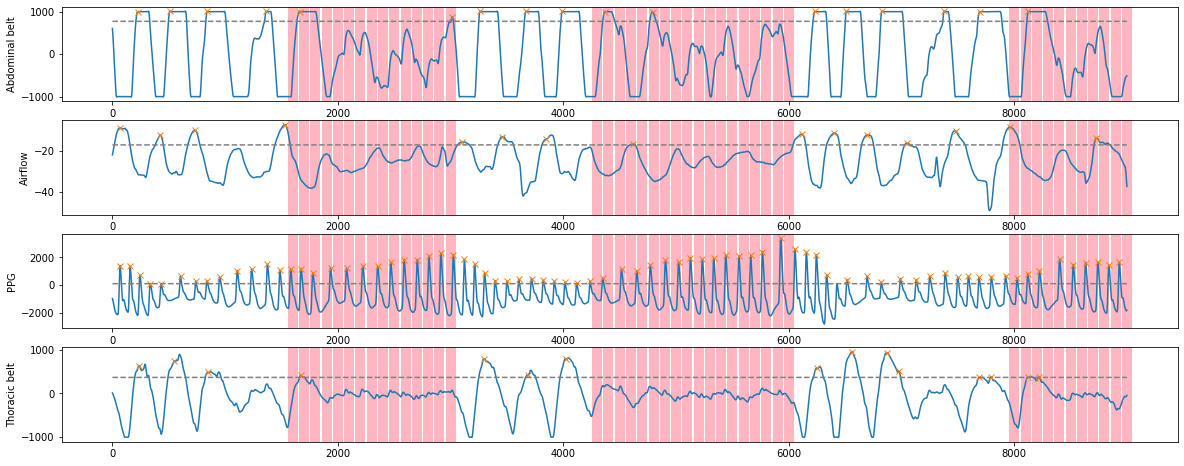

In [56]:
signal_id = idx_apnea_signals[500]
apneas_i = np.where(mask[signal_id] == 1)[0]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    for idx in range(apneas_i.size):
        ax[i].axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    time_diff_peaks = []
    #peaks, _ = sg.find_peaks(signal_i,height=0)
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
    ax[i].set_ylabel(labels[i])
    
    

In [335]:
def peak_features_extractor(signal_id, dim, n_window=500, peak_param=1, time_treshold=0.5, plot=False):
    
    '''
    Returns matrix of shape 9000 which computes the distance to the closest peak, as well as the
    average value of the signal on a window of size n_window
    
    '''
    
    signal_i = X_train[dim, signal_id]
    treshold = signal_i.mean()+ peak_param*signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, mean = keep_peaks(peaks, time_treshold)
    peaks_added = np.zeros(2 + peaks.size)
    peaks_added[1:-1] = peaks
    peaks_added[-1] = signal_i.size-1
    
    dist_matrix = np.zeros((signal_i.size,3))
    mean_window = np.ones(n_window) / n_window
    
    next_peak_idx = 1
    prev_peak_idx = 0
    
    
    for i in range(signal_i.size):
        dist_matrix[i,0] = (i - peaks_added[prev_peak_idx])/100
        dist_matrix[i,1] = (peaks_added[next_peak_idx] - i)/100
        
        if i == peaks_added[next_peak_idx]:
            next_peak_idx +=1
            prev_peak_idx +=1
            
    
    dist_matrix[:, 2] = np.convolve(signal_i, n_window, 'same' )
    
    
    if plot:
        fig, ax = plt.subplots(figsize=(20,5))
        apneas_i = np.where(mask[signal_id] == 1)[0]
        for idx in range(apneas_i.size):
            ax.axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
        
        ax.plot(signal_i)
        ax.plot(peaks, signal_i[peaks], "x")
        ax.plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
        ax.set_ylabel(labels[dim])
        
    
    return(dist_matrix)
        

bandpass filters on eeg

In [200]:

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

Signal 0
Average interval between peaks : 3.92, var : 12.98, median : 2.54, min : 1.86, max : 14.39  
Signal 1
Average interval between peaks : 6.01, var : 17.48, median : 3.84, min : 2.87, max : 15.70  
Signal 2
Average interval between peaks : 1.17, var : 0.06, median : 1.09, min : 0.87, max : 1.80  
Signal 3
Average interval between peaks : 5.30, var : 34.60, median : 2.99, min : 0.66, max : 21.44  


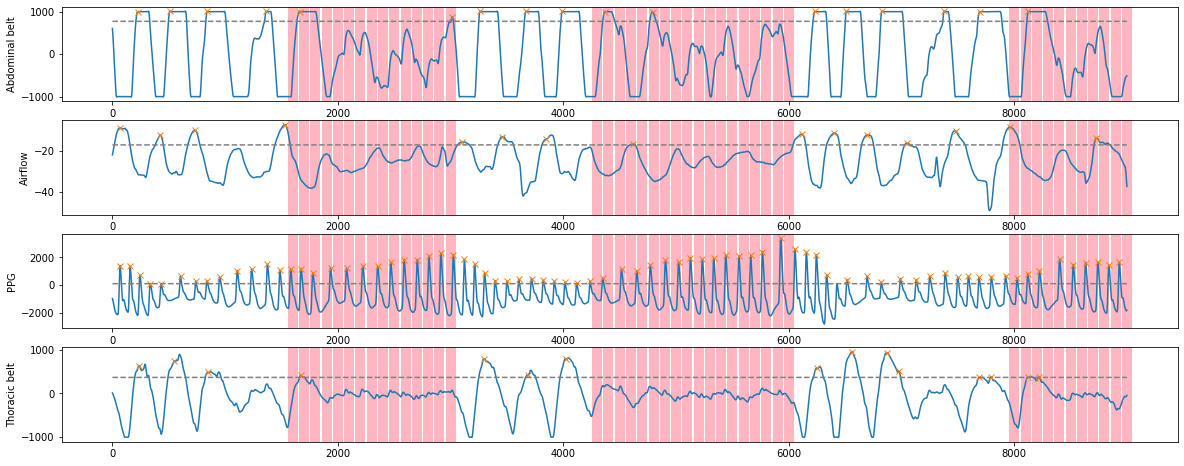

In [204]:
signal_id = idx_apnea_signals[500]
apneas_i = np.where(mask[signal_id] == 1)[0]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    for idx in range(apneas_i.size):
        ax[i].axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    time_diff_peaks = []
    #peaks, _ = sg.find_peaks(signal_i,height=0)
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
    ax[i].set_ylabel(labels[i])
    
    

In [327]:
y_alpha = butter_bandpass_filter(signal_apnea, 8, 12, fs, order=3)
y_beta = butter_bandpass_filter(signal_apnea, 16, 40, fs, order=3)
y_sigma = butter_bandpass_filter(signal_apnea, 12, 16, fs, order=3)
y_delta = butter_bandpass_filter(signal_apnea, 0.25, 4, fs, order=3)
y_theta = butter_bandpass_filter(signal_apnea, 4, 8, fs, order=3)

y_bands = np.asarray([y_delta, y_theta, y_alpha, y_sigma, y_beta])


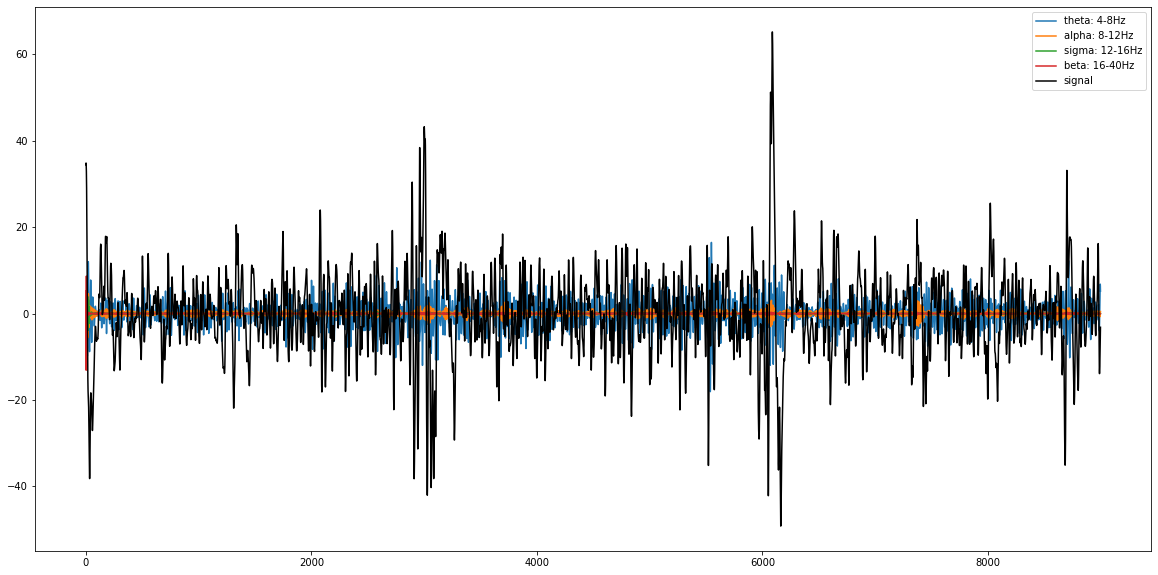

In [328]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(y_delta, label="delta: 0.25-4Hz")
ax.plot(y_theta, label="theta: 4-8Hz")
ax.plot(y_alpha, label="alpha: 8-12Hz ")
ax.plot(y_sigma, label="sigma: 12-16Hz")
ax.plot(y_beta, label="beta: 16-40Hz")
ax.plot(signal_apnea, c='k', label='signal')
ax.legend()

Text(0.5, 1.0, "Zoom sur le signal pendant une épisode d'apnée")

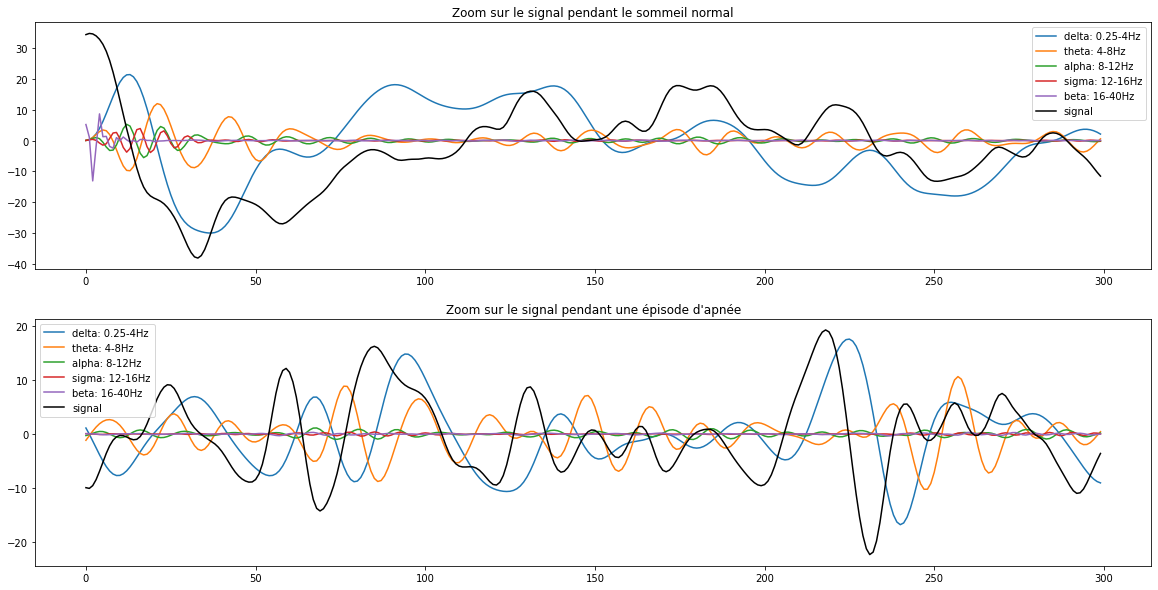

In [330]:
#plt.plot(y_alpha)
#plt.plot(y_beta)
#plt.plot(y_delta)

fig, (ax,ax1) = plt.subplots(nrows = 2, figsize=(20,10))
ax.plot(y_delta[:300], label="delta: 0.25-4Hz")
ax.plot(y_theta[:300], label="theta: 4-8Hz")
ax.plot(y_alpha[:300], label="alpha: 8-12Hz ")
ax.plot(y_sigma[:300], label="sigma: 12-16Hz")
ax.plot(y_beta[:300], label="beta: 16-40Hz")
ax.plot(signal_apnea[:300], c='k', label='signal')
ax.legend()
ax.set_title("Zoom sur le signal pendant le sommeil normal")

#ax1.plot(np.cumsum(y_delta[:100]**2), label="delta: 0.25-4Hz")
ax1.plot(y_delta[2500:2800], label="delta: 0.25-4Hz")
ax1.plot(y_theta[2500:2800], label="theta: 4-8Hz")
ax1.plot(y_alpha[2500:2800], label="alpha: 8-12Hz ")
ax1.plot(y_sigma[2500:2800], label="sigma: 12-16Hz")
ax1.plot(y_beta[2500:2800], label="beta: 16-40Hz")
ax1.plot(signal_apnea[2500:2800], c='k', label='signal')
ax1.legend()
ax1.set_title("Zoom sur le signal pendant une épisode d'apnée")

In [447]:
from scipy.stats import mode, skew

signals = ["d", "t", "a", "s", "b"]
features = ["energy", "entropy", "variance", "std", "mean", "median", "mode", "min", "max", "skew"]

def energy(signal):
    return(np.sum(signal**2))

def entropy(signal):
    return(np.sum(signal**2*np.log(signal**2)))

def features_subsignal(signal):
    ener = energy(signal)
    entro = entropy(signal)
    var = signal.var()
    std = signal.std()
    mean = signal.mean()
    median = np.median(signal)
    mod = mode(signal)[0][0]
    mini = signal.min()
    maxi = signal.max()
    
    return(np.asarray([ener,entro,var,std,mean,median,mod,mini,maxi]))

def features_signal(signal, half_window_size=150, window_overlap=15):
    
    l_features = []
    
    i=0
    cnt =0
    while i < half_window_size:
        l_features += [features_subsignal(signal[:i + half_window_size])]
        i += window_overlap
        cnt +=1

    while i + half_window_size < signal.size :
        l_features += [features_subsignal(signal[i-half_window_size: i + half_window_size ])]
        i += window_overlap
        cnt +=1
    while i < signal.size:
        l_features += [features_subsignal(signal[i-half_window_size: ])]
        i += window_overlap
        cnt +=1
    return(np.asarray(l_features))
        
        


In [448]:
def signal_features_extractor(signal_idx, half_window_size=150, window_overlap= 15, n_window=100, peak_param=1, time_treshold=0.5):
    
    n_samples, idx = compute_idx(half_window_size, window_overlap, signal.size)
    
    feature_matrix = np.zeros((n_samples, 3*4+9*5*2))
    
    for i in range(4):
        feature_matrix[:, 3*i:3*(i+1)] = peak_features_extractor(signal_id, dim=i, n_window=n_window,
                                                peak_param=peak_param, time_treshold=time_treshold)[idx]
    
    col_idx = 12
    for i in [6,7]:
        
        y_alpha = butter_bandpass_filter(X_train[i, signal_idx], 8, 12, fs, order=3)
        y_beta = butter_bandpass_filter(X_train[i, signal_idx], 16, 40, fs, order=3)
        y_sigma = butter_bandpass_filter(X_train[i, signal_idx], 12, 16, fs, order=3)
        y_delta = butter_bandpass_filter(X_train[i, signal_idx], 0.25, 4, fs, order=3)
        y_theta = butter_bandpass_filter(X_train[i, signal_idx], 4, 8, fs, order=3)
        
        feature_matrix[:, col_idx:col_idx+9] = features_signal(y_alpha, half_window_size, window_overlap)
        col_idx +=9
        feature_matrix[:, col_idx:col_idx+9] = features_signal(y_beta, half_window_size, window_overlap)
        col_idx +=9
        feature_matrix[:, col_idx:col_idx+9] = features_signal(y_sigma, half_window_size, window_overlap)
        col_idx +=9
        feature_matrix[:, col_idx:col_idx+9] = features_signal(y_delta, half_window_size, window_overlap)
        col_idx +=9
        feature_matrix[:, col_idx:col_idx+9] = features_signal(y_theta, half_window_size, window_overlap)
        col_idx +=9
        
    return(feature_matrix)
        

        
    
    

In [449]:
def peak_features_extractor(signal_id, dim, n_window=100, peak_param=1, time_treshold=0.5, plot=False):
    
    '''
    Returns matrix of shape 9000 which computes the distance to the closest peak, as well as the
    average value of the signal on a window of size n_window
    
    '''
    
    signal_i = X_train[dim, signal_id]
    treshold = signal_i.mean()+ peak_param*signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, mean = keep_peaks(peaks, time_treshold)
    peaks_added = np.zeros(2 + peaks.size)
    peaks_added[1:-1] = peaks
    peaks_added[-1] = signal_i.size-1
    
    dist_matrix = np.zeros((signal_i.size,3))
    mean_window = np.ones(n_window) / n_window
    
    next_peak_idx = 1
    prev_peak_idx = 0
    
    
    for i in range(signal_i.size):
        dist_matrix[i,0] = (i - peaks_added[prev_peak_idx])/100
        dist_matrix[i,1] = (peaks_added[next_peak_idx] - i)/100
        
        if i == peaks_added[next_peak_idx]:
            next_peak_idx +=1
            prev_peak_idx +=1
            
    
    dist_matrix[:, 2] = np.convolve(signal_i, n_window, 'same' )
    
    
    if plot:
        fig, ax = plt.subplots(figsize=(20,5))
        apneas_i = np.where(mask[signal_id] == 1)[0]
        for idx in range(apneas_i.size):
            ax.axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
        
        ax.plot(signal_i)
        ax.plot(peaks, signal_i[peaks], "x")
        ax.plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
        ax.set_ylabel(labels[dim])
        
    
    return(dist_matrix)
        

In [450]:
def compute_idx(half_window, overlap, length):
    cnt = 0
    idx = []
    i=0
    while i + half_window < length:
        cnt+=1
        idx +=[i]
        i += overlap
    while i < length:
        cnt+=1
        idx +=[i]
        i += overlap
        
    return(cnt, idx)
        

In [456]:
features_patient1 = np.zeros((200,600,102))


for i in range(200):
    features_patient1[i] = signal_features_extractor(i)
    if i%10 == 0:
        print(f"Extracted features of {i+1} signals")
    

Extracted features of 1 signals
Extracted features of 11 signals
Extracted features of 21 signals
Extracted features of 31 signals
Extracted features of 41 signals
Extracted features of 51 signals
Extracted features of 61 signals
Extracted features of 71 signals
Extracted features of 81 signals
Extracted features of 91 signals
Extracted features of 101 signals
Extracted features of 111 signals
Extracted features of 121 signals
Extracted features of 131 signals
Extracted features of 141 signals
Extracted features of 151 signals
Extracted features of 161 signals
Extracted features of 171 signals
Extracted features of 181 signals
Extracted features of 191 signals


In [ ]:
features_patient1_ = feat

In [461]:
h5f = h5py.File('features/patient1.h5', 'w')
h5f.create_dataset('data', data=features_patient1)
h5f.close()